# PDS classification with the PDSclassifier package

- [Paper](https://www.nature.com/articles/s41588-024-01654-5)
- [GitHub](https://github.com/sidmall/PDSclassifier?tab=readme-ov-file)

>PDSclassifier R package provides a pathway-based molecular classification system for colorectal cancer (CRC), which can be applied to gene expression profiles to stratify into three Pathway-Derived Subtype (PDS): PDS1, PDS2 and PDS3, with distinct molecular biology.

>We defined three pathway-derived subtypes (PDS) in CRC: 
>- PDS1 tumors, which are canonical/LGR5+ stem-rich, highly proliferative and display good prognosis;
>- PDS2 tumors, which are regenerative/ANXA1+ stem-rich, with elevated stromal and immune tumor microenvironmental lineages;
>- PDS3 tumors, which represent a previously overlooked slow-cycling subset of tumors within CMS2 with reduced stem populations and increased differentiated lineages, particularly enterocytes and enteroendocrine cells, yet display the worst prognosis in locally advanced disease. These PDS3 phenotypic traits are evident across numerous bulk and single-cell datasets, and demark a series of subtle biological states that are currently under-represented in pre-clinical models and are not identified using existing subtyping classifiers.

The CMS to PDS associations that they found in different sample sets, in figure 2c and extended data figure 1d:

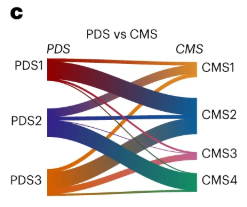
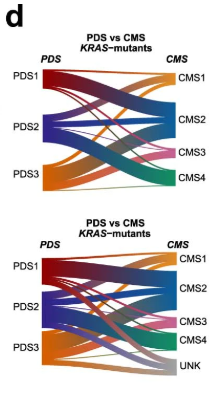

In [ ]:
if (!"PDSclassifier" %in% installed.packages()) {devtools::install_github('sidmall/PDSclassifier')}
if (!"escape" %in% installed.packages()) {BiocManager::install("escape")}

library(PDSclassifier)
library(tidyverse)
load("/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/resources/sysdata.rda")

In [ ]:
input_file = "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/adata_subset_stripped.h5ad"
output_csv = "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/PDS_classifier.csv"
clusters_file = "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/clusters_scmiko_subset_chosen_res.csv"

In [85]:
suppressPackageStartupMessages({library(Seurat)})
srt = schard::h5ad2seurat(input_file)
srt[['RNA']]$data = as.matrix(schard::h5ad2Matrix(input_file, name = "/layers/log1p_norm_of_counts"))
stopifnot(!(all(srt[['RNA']]$data[1:50]%%1 == 0))) # check values (not integer)
names(srt@reductions) = c('diffmap', 'pca', 'tsne', 'umap')

# set colors for PDS types
pds_col = c("#f8776e", "#7cae00", "#c77dff", "grey")

srt

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.9 GiB”


An object of class Seurat 
11449 features across 22799 samples within 1 assay 
Active assay: RNA (11449 features, 0 variable features)
 2 layers present: counts, data
 4 dimensional reductions calculated: diffmap, pca, tsne, umap

The function does not work with our data because not all predictors from their SVM model could be computed, probably because of some missing genes. We can fix that by adding the missing predictors with only zero values so that they do not affect the results.

In [5]:
# fixed function from package
PDSpredict_fixed = function(x, species, threshold = 0.6) {
    ### examine if  '///' string genes are present and any duplicated genes
    if (nrow(x[duplicated(gsub("\\s.*", "", x[, 1])), ]) > 0){
    x <- highMeanGene(x)
    } else {
    rownames(x) <- x[,1]
    x <- x[,-1]
    x <- as.matrix(x)
    }

    ### Get the C2 (BIOCARTA, KEGG, PID, REACTOME) gene set, saved from MSigDB
    if (species == "mouse") {

    c2.geneset <- mouse.c2.geneset.list

    } else {

    c2.geneset <- human.c2.geneset.list
    }

    ### default threshold = 0.6
    if (threshold < 0 | threshold > 1) {
    stop('Set threshold between 0 and 1')
    } else {
    threshold <- threshold}

    ### Generate single sample GSEA scores (ssGSEA)
    message('Calculating ssGSEA scores...')
    ### set seed
    if (as.Date(paste0(R.version$year,'-',R.version$month,'-',R.version$day)) >= as.Date('2019-04-26'))
    {suppressWarnings(set.seed(123, sample.kind = 'Rounding'))} else{set.seed(123)}


    ### package version change of GSVA
    if(utils::packageVersion("GSVA") <= "1.48.3" ) {

        ### ssGSEA
        y <- suppressWarnings(GSVA::gsva(x, c2.geneset, max.sz = Inf, ## min.size default as it may lead to no gene set scores
                                            verbose = F, method = "ssgsea", parallel.sz = 4,
                                            ssgsea.norm = F))

    } else {

        ### ssGSEA -- update
        ssgsea_par <- GSVA::ssgseaParam(x, c2.geneset,
                                        maxSize = Inf, ## min.size default as it may lead to no gene set scores
                                        normalize = F)
        y <- suppressWarnings(GSVA::gsva(ssgsea_par, verbose = F, BPPARAM = BiocParallel::SnowParam(workers = 4)))

    }

    ### Apply scaling with fixed value from training set.
    minmax_diff <- 20928.93
    y.1 <- as.data.frame(sapply(as.data.frame(y), function(s) {s/(minmax_diff)}))
    rownames(y.1) <- rownames(y)
    y.1 <- as.data.frame(y.1)
    y.1[['gs_name']] <- rownames(y.1)
    y.1 <- dplyr::select(y.1, c('gs_name', dplyr::everything()))
    y.1$gs_name <- gsub('\\.', ':', y.1$gs_name)
    cat("ssGSEA Complete!\n")


    ### train data
    train.data.1 <- trainData[,-c(1:2)]
    rownames(train.data.1) <- trainData[,1]
    train.data.1 <- as.data.frame(t(train.data.1))
    train.data.1[['gs_name']] <- rownames(train.data.1)
    train.data.1 <- dplyr::select(train.data.1, c('gs_name', dplyr::everything()))

    ### merge traindata with new data
    merge.1 <- merge(train.data.1, y.1, by = "gs_name")
    rownames(merge.1) <- merge.1[["gs_name"]]
    merge.1 <- merge.1[,-1]
    nrow(train.data.1) == nrow(merge.1)

    ### check for batch effect
    message('Batch Correction (with training set as reference batch)...')
    combi <- suppressMessages(sva::ComBat(dat = as.matrix(merge.1),
                                        batch = c(rep(1,ncol(train.data.1[,-1])),
                                                    rep(2,ncol(y.1[,-1]))),
                                        mod = NULL,
                                        ref.batch = 1,
                                        par.prior = T,
                                        prior.plots = F))

    cat("Batch Correction Complete!\n")

    ############# It fails here. There are missing predictors
    
    missing_predictors <- setdiff(rownames(train.data.1), rownames(combi))

    # Add rows for the missing predictors, setting their values to 0
    for (predictor in missing_predictors) {
        new_row <- matrix(0, nrow = 1, ncol = ncol(combi))
        rownames(new_row) <- predictor
        combi <- rbind(combi, new_row)
    }

    # Ensure the predictors are in the correct order
    combi <- combi[rownames(train.data.1), , drop = FALSE]
    stopifnot(nrow(combi) == nrow(train.data.1))

    combi.train.data <- combi[, c(1:ncol(train.data.1[,-1]))]
    new.data.mtx <- combi[,c((ncol(train.data.1[,-1])+1):(ncol(train.data.1[,-1])+ncol(y.1[,-1])))]


    message('Applying the svmRBF classification model...')

    ### Set the seed for reproducibility
    if (as.Date(paste0(R.version$year,'-',R.version$month,'-',R.version$day)) >= as.Date('2019-04-26'))
    {suppressWarnings(set.seed(40218336, sample.kind = 'Rounding'))} else{set.seed(40218336)}

    svm.predict <- stats::predict(svm.model, t(new.data.mtx))

    ### Final decision on prediction calls
    PDS.predict <- stats::predict(svm.model, t(new.data.mtx), type = "prob")
    rownames(PDS.predict) <- rownames(t(new.data.mtx))
    PDS.predict[['Sample_ID']] <- rownames(PDS.predict)
    PDS.predict <- dplyr::select(PDS.predict, c('Sample_ID', dplyr::everything()))
    PDS.predict <- data.frame(PDS.predict, prediction = svm.predict)

    PDS.predict[["PDS_call"]] <- ifelse(PDS.predict[["PDS1"]] > threshold, "PDS1",
                                        ifelse(PDS.predict[["PDS2"]] > threshold, "PDS2",
                                                ifelse(PDS.predict[["PDS3"]] > threshold, "PDS3", "Mixed")))

    cat("Classification Complete!\n")
    if(any(rownames(utils::installed.packages()) %in% "beepr"))
        beepr::beep(sound = 4)


    PDS.predict <- dplyr::mutate(PDS.predict, PDS_call = factor(PDS.predict$PDS_call,
                                                                levels = c('PDS1', 'PDS2',
                                                                            'PDS3', 'Mixed')))

    return(PDS.predict)
}

## Pseudo-bulk per cluster

First, I will apply the PDSclassifier to the pseudo-bulk data per cluster. We expect the clusters to be distinct from each other, possibly with different PDS subtypes.

In [6]:
clusters = read.csv(clusters_file) |> dplyr::rename(cluster = !!2) |> tibble::column_to_rownames("X")
stopifnot(all(rownames(srt@meta.data) == rownames(clusters))) # check if same cells
srt$clusters = clusters

In [7]:
# Here we use AverageExpression instead of AggregateExpression to create pseudobulk data because we want to use normalized data
aex_per_cluster = AverageExpression(srt, layer = "data", assays = "RNA", 
                                    return.seurat = F, group.by = "clusters")
aex_per_cluster = as.data.frame(aex_per_cluster$RNA)

# rownames to first column
aex_per_cluster$Gene.Symbol = rownames(aex_per_cluster)
aex_per_cluster = aex_per_cluster[,c(ncol(aex_per_cluster), 1:(ncol(aex_per_cluster)-1))]
rownames(aex_per_cluster) = NULL
head(aex_per_cluster)

PDS.predict_per_cluster = PDSpredict_fixed(x = aex_per_cluster, species = 'human', threshold = 0.6)
PDS.predict_per_cluster

As of Seurat v5, we recommend using AggregateExpression to perform pseudo-bulk analysis.
This message is displayed once per session.


First group.by variable `clusters` starts with a number, appending `g` to ensure valid variable names
This message is displayed once every 8 hours.


Gene.Symbol g0         g1         g2         g3         g4         g5        
1 NOC2L       0.69089635 0.49842556 0.38228022 0.60838501 0.64282905 1.07569246
2 KLHL17      0.02876912 0.02790077 0.03459011 0.02942223 0.02532143 0.03645178
3 PLEKHN1     0.04404978 0.10089086 0.11712676 0.08025593 0.01642528 0.05224939
4 HES4        0.03937585 0.04482053 0.07085190 0.03108426 0.01163556 0.08401970
5 ISG15       0.53500548 1.04627816 0.85616892 1.61423869 0.52262672 0.90936614
6 AGRN        1.61798918 2.05596588 2.18839549 1.95829979 2.23350511 0.29436614
  g6         
1 0.618564165
2 0.029135362
3 0.022118364
4 0.004840012
5 1.070964242
6 1.153269623

Calculating ssGSEA scores...



[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
ssGSEA Complete!


Batch Correction (with training set as reference batch)...



Batch Correction Complete!


Applying the svmRBF classification model...



Classification Complete!


Sample_ID PDS1        PDS2       PDS3       prediction PDS_call
g0 g0        0.928741574 0.04267948 0.02857894 PDS1       PDS1    
g1 g1        0.006084296 0.19144291 0.80247280 PDS3       PDS3    
g2 g2        0.006095604 0.33741576 0.65648863 PDS3       PDS3    
g3 g3        0.069711769 0.28365783 0.64663040 PDS3       PDS3    
g4 g4        0.059408438 0.67337714 0.26721442 PDS2       PDS2    
g5 g5        0.821522373 0.15173425 0.02674338 PDS1       PDS1    
g6 g6        0.105726403 0.11145973 0.78281387 PDS3       PDS3

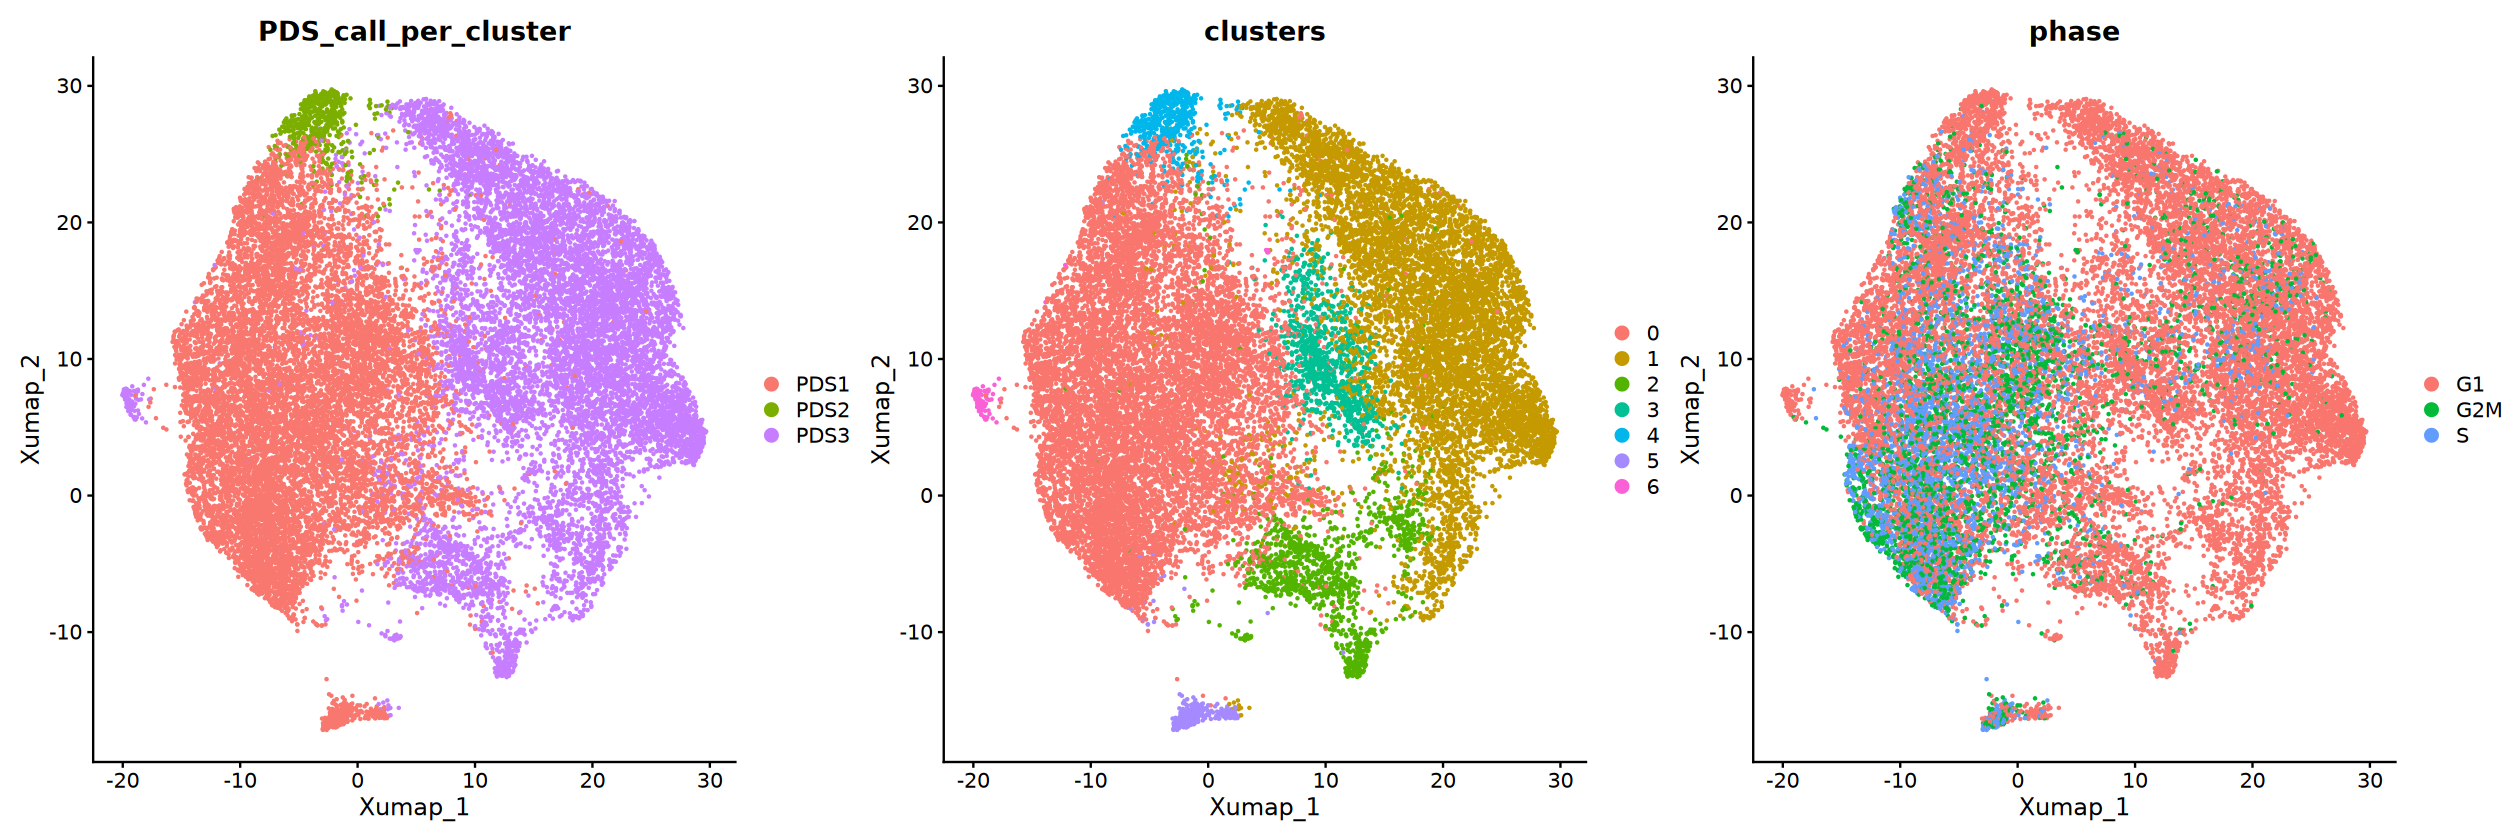

In [ ]:
# add to cell annotation and save
srt$PDS_call_per_cluster = PDS.predict_per_cluster$PDS_call[
    match(paste0('g', srt$clusters), PDS.predict_per_cluster$Sample_ID)]
write.csv(srt$PDS_call_per_cluster, output_csv, row.names = T)

options(repr.plot.width = 21, repr.plot.height = 7)
p1 = DimPlot(srt, group.by = "PDS_call_per_cluster", reduction = "umap", 
             cols = pds_col, na.value="lightgrey")
p2 = DimPlot(srt, group.by = "clusters", reduction = "umap")
p3 = DimPlot(srt, group.by = "phase", reduction = "umap")
p1 + p2 + p3

## Pseudo-bulk per sample and cluster

Do the clusters represent clearly different PDS types, or do clusters _transition_ from one type to the other because something else determines the clusters?

In [9]:
aex_per_sample_and_cluster = AverageExpression(srt, layer = "data", assays = "RNA", 
                                               return.seurat = F, group.by = c("sample", "clusters"))
aex_per_sample_and_cluster = as.data.frame(aex_per_sample_and_cluster$RNA)

# rownames to first column
aex_per_sample_and_cluster$Gene.Symbol = rownames(aex_per_sample_and_cluster)
aex_per_sample_and_cluster = aex_per_sample_and_cluster[,c(ncol(aex_per_sample_and_cluster), 1:(ncol(aex_per_sample_and_cluster)-1))]
rownames(aex_per_sample_and_cluster) = NULL
head(aex_per_sample_and_cluster)

Names of identity class contain underscores ('_'), replacing with dashes ('-')
This message is displayed once every 8 hours.


Gene.Symbol C-1_0      C-1_1      C-1_2      C-1_3      C-1_4      C-1_5     
1 NOC2L       0.73946001 0.24505644 0.56622783 0.56905393 0.47511427 1.60838163
2 KLHL17      0.02130700 0.04861371 0.03837035 0.04204711 0.07796266 0.04773485
3 PLEKHN1     0.04305652 0.19122409 0.06770698 0.11543743 0.00000000 0.25451327
4 HES4        0.02767052 0.15461772 0.01534919 0.04888846 0.02141061 0.50236501
5 ISG15       0.54000629 1.39095316 0.56370048 2.15638530 0.25034387 0.57668146
6 AGRN        1.58832685 1.64051671 2.67286591 1.22217002 2.16969594 0.21461172
  C-1_6     C-2_0      C-2_1     ⋯ OnOff-4_3 OnOff-4_4 OnOff-4_5  OnOff-5_0 
1 1.0899499 0.66897758 0.5926808 ⋯ 0.4921197 0.6289574 0.26801100 0.70007800
2 0.0000000 0.03516887 0.0000000 ⋯ 0.0000000 0.0000000 0.00000000 0.04206775
3 0.0000000 0.04084753 0.0108106 ⋯ 0.1959118 0.0000000 0.07930215 0.04743924
4 0.0000000 0.03859184 0.1625672 ⋯ 0.1289770 0.0000000 0.00000000 0.05835791
5 2.8320013 0.66464707 0.9692359 ⋯ 0.6791728 0.6104370 0.19432179 0.38279004
6 0.6727525 1.64849346 1.7476067 ⋯ 1.5600199 0.2945829 0.34238127 1.54610532
  OnOff-5_1  OnOff-5_2  OnOff-5_3  OnOff-5_4 OnOff-5_5 OnOff-5_6
1 0.38079769 0.59498884 0.51608768 0.2084800 0.7020366 0.8939397
2 0.02582693 0.15383975 0.00000000 0.0000000 0.0667461 0.0000000
3 0.12632141 0.00000000 0.08136897 0.0000000 0.0000000 0.0000000
4 0.05078993 0.05949254 0.19798431 0.0000000 0.1499832 0.0000000
5 1.10346638 1.24096501 0.75807237 0.1585136 0.2310031 0.5232315
6 1.34788865 2.35845784 2.12880429 1.7873419 0.2244902 0.4309552

In [10]:
PDS.predict_per_sample_and_cluster = PDSpredict_fixed(x = aex_per_sample_and_cluster, species = 'human', threshold = 0.6)
PDS.predict_per_sample_and_cluster |> head()

Calculating ssGSEA scores...



[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
ssGSEA Complete!


Batch Correction (with training set as reference batch)...



Batch Correction Complete!


Applying the svmRBF classification model...



Classification Complete!


Sample_ID PDS1       PDS2       PDS3       prediction PDS_call
C-1_0 C-1_0     0.93066215 0.05577958 0.01355827 PDS1       PDS1    
C-1_1 C-1_1     0.13685046 0.57216668 0.29098286 PDS2       Mixed   
C-1_2 C-1_2     0.03927875 0.47930504 0.48141621 PDS3       Mixed   
C-1_3 C-1_3     0.34773955 0.42341933 0.22884111 PDS2       Mixed   
C-1_4 C-1_4     0.07307585 0.72160788 0.20531627 PDS2       PDS2    
C-1_5 C-1_5     0.85507708 0.12626208 0.01866084 PDS1       PDS1

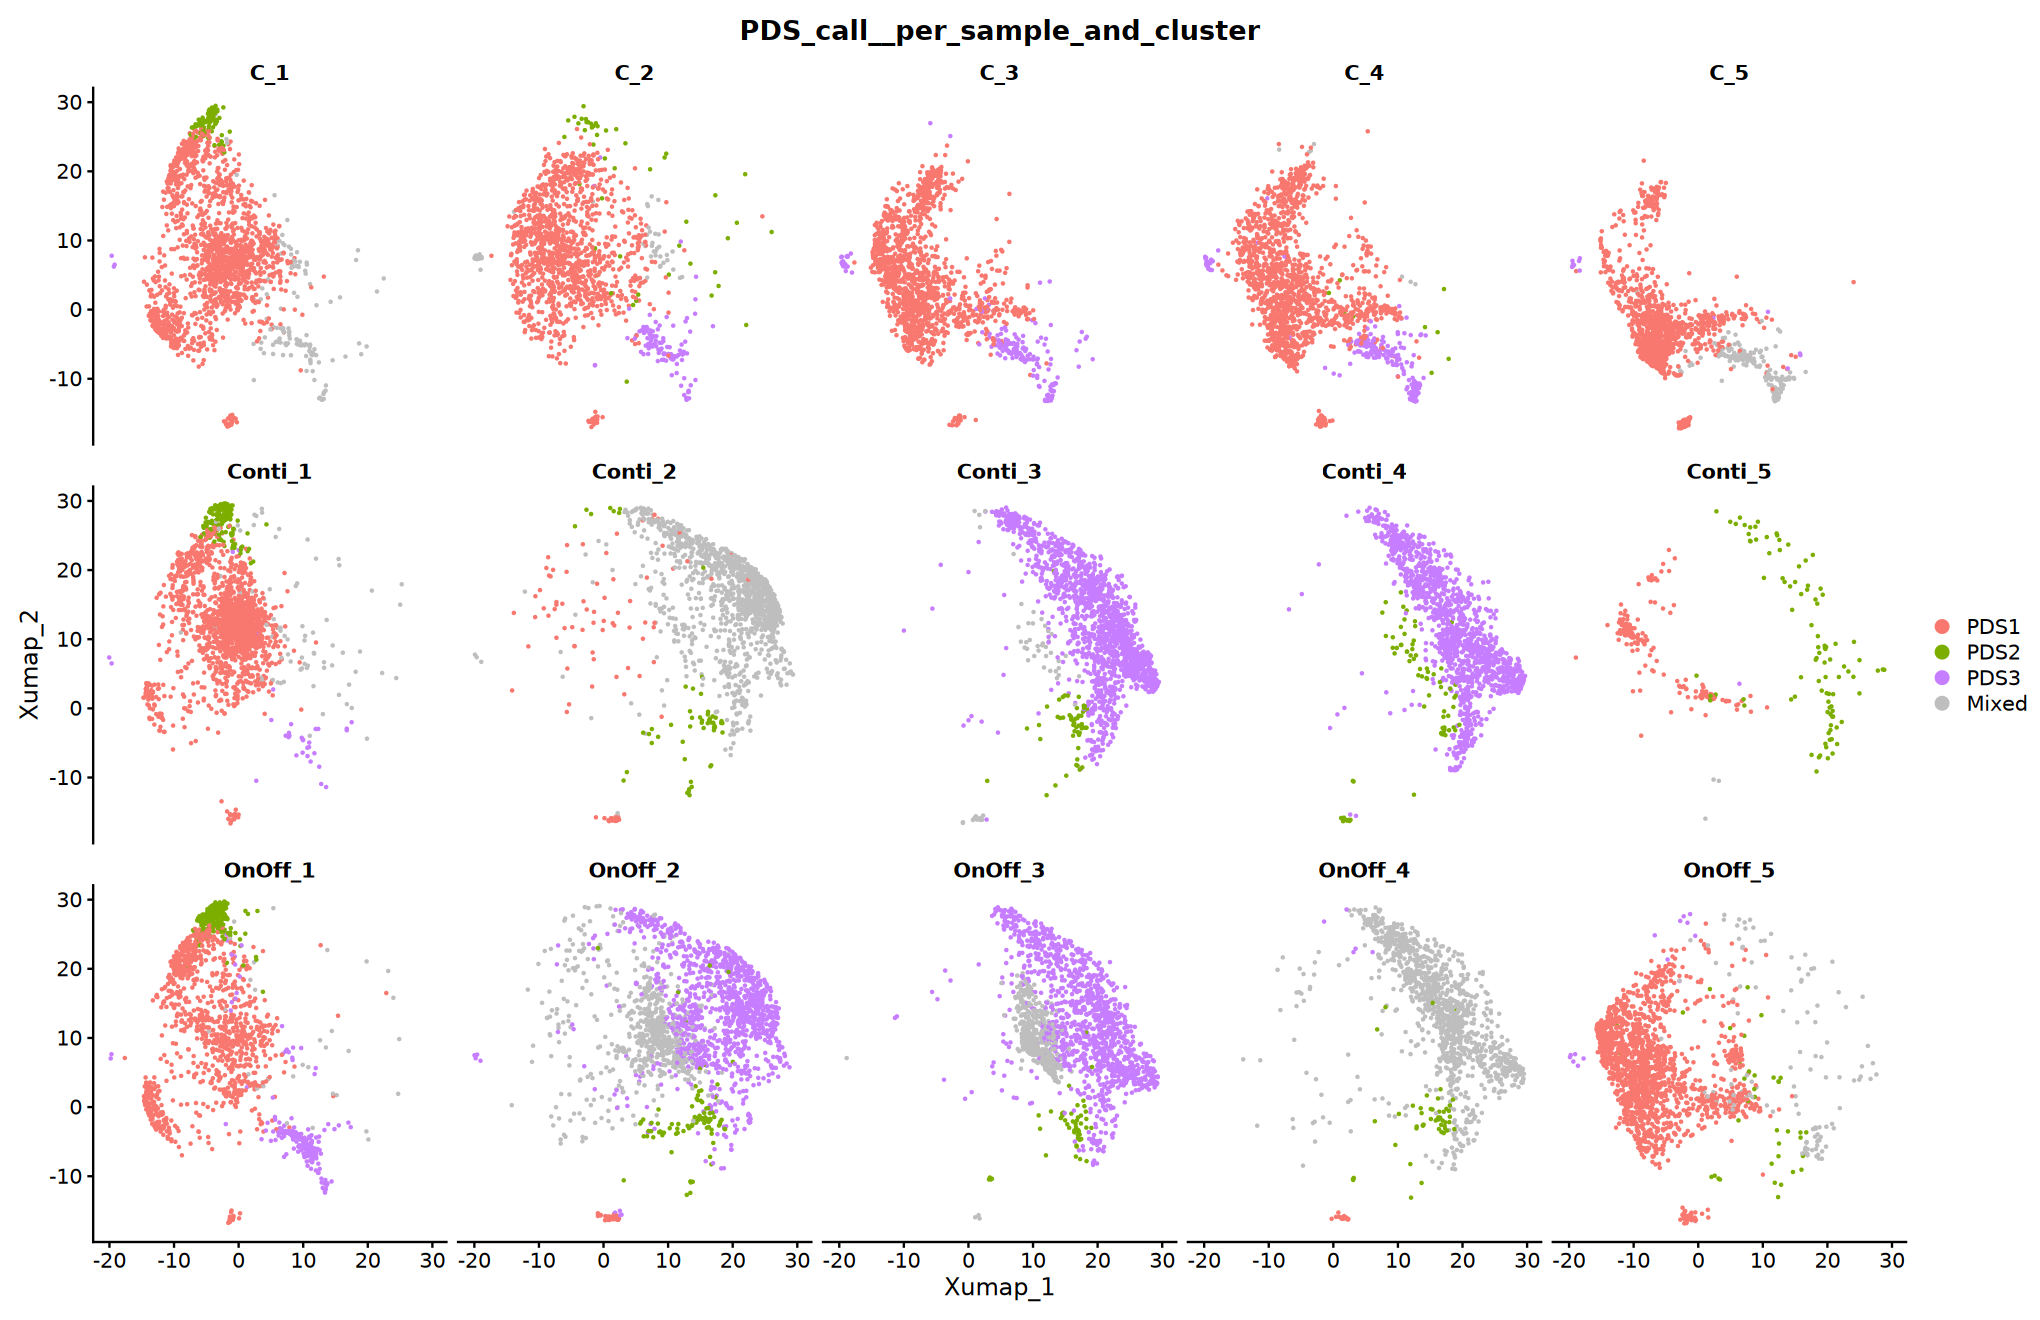

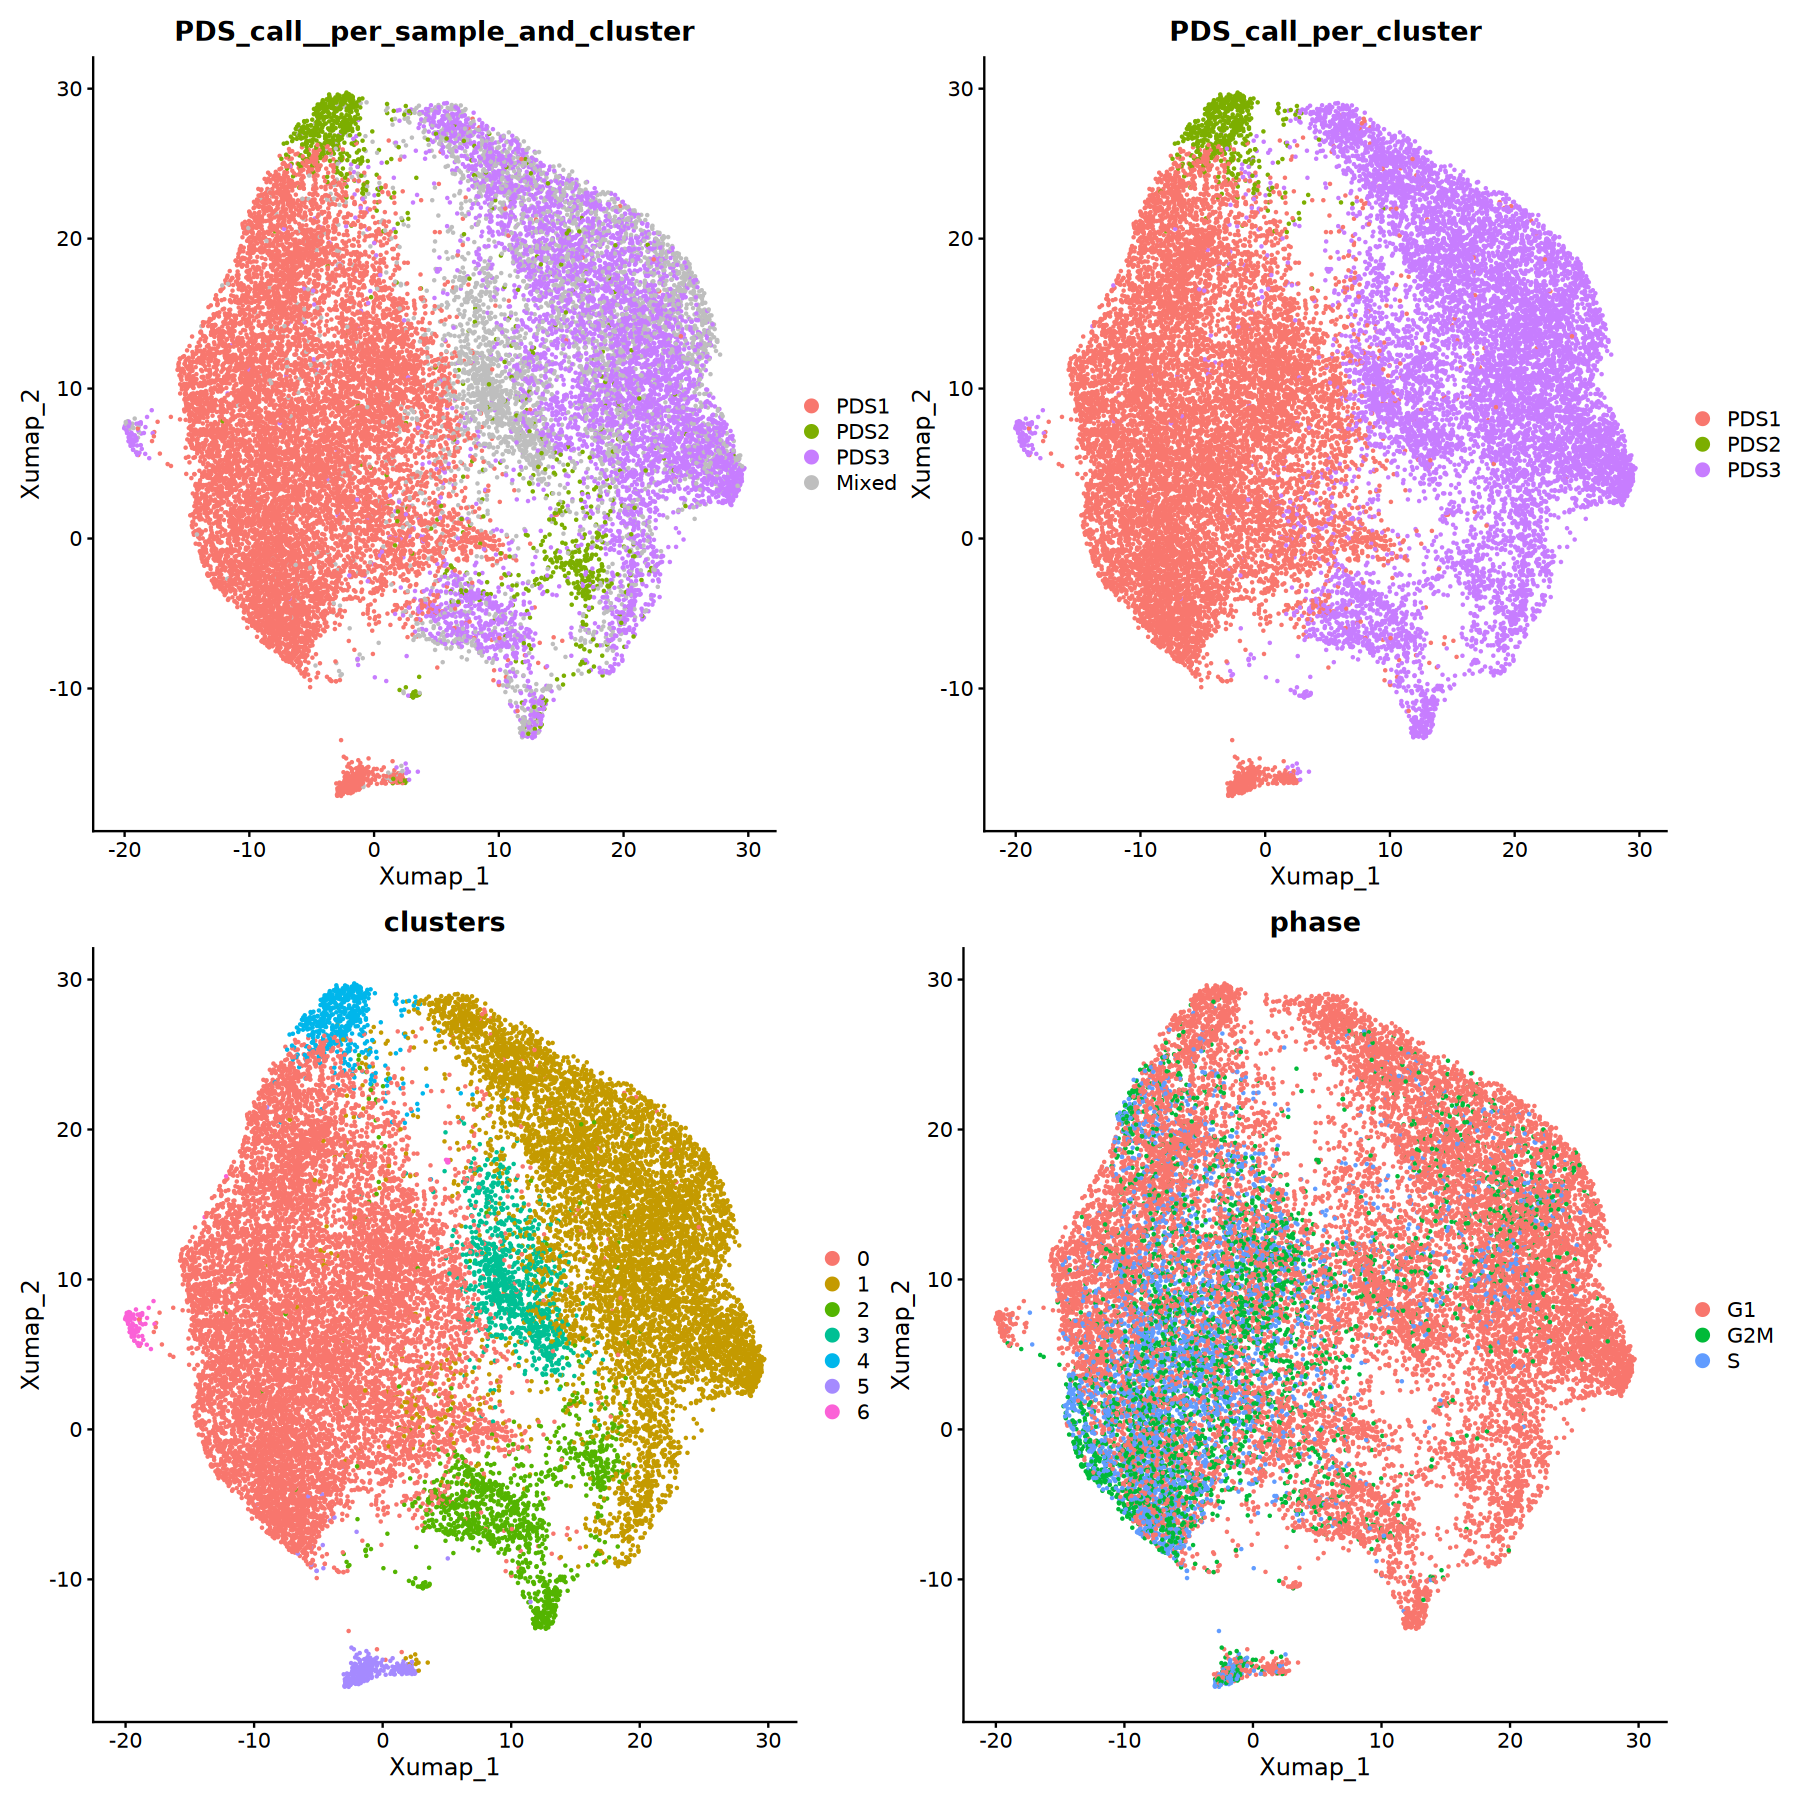

In [ ]:
srt$PDS_call__per_sample_and_cluster = PDS.predict_per_sample_and_cluster$PDS_call[match(paste0(gsub("_", "-", gsub("_", "-", srt$sample)), '_', srt$clusters), PDS.predict_per_sample_and_cluster$Sample_ID)]

options(repr.plot.width = 17, repr.plot.height = 11)
DimPlot(srt, group.by = "PDS_call__per_sample_and_cluster", reduction = "umap", split.by = "sample", 
        ncol = 5, cols = pds_col, na.value="lightgrey")

options(repr.plot.width = 15, repr.plot.height = 15)
p4 = DimPlot(srt, group.by = "PDS_call__per_sample_and_cluster", reduction = "umap", 
             cols = pds_col, na.value="lightgrey")
(p4 + p1) / (p2 + p3)

In [50]:
# add a column to the metadata with the number of cells per cluster and sample
srt$cells_per_cluster = as.numeric(table(paste0(srt$sample, '_', srt$clusters))[
    match(paste0(srt$sample, '_', srt$clusters), 
    names(table(paste0(srt$sample, '_', srt$clusters))))
    ])

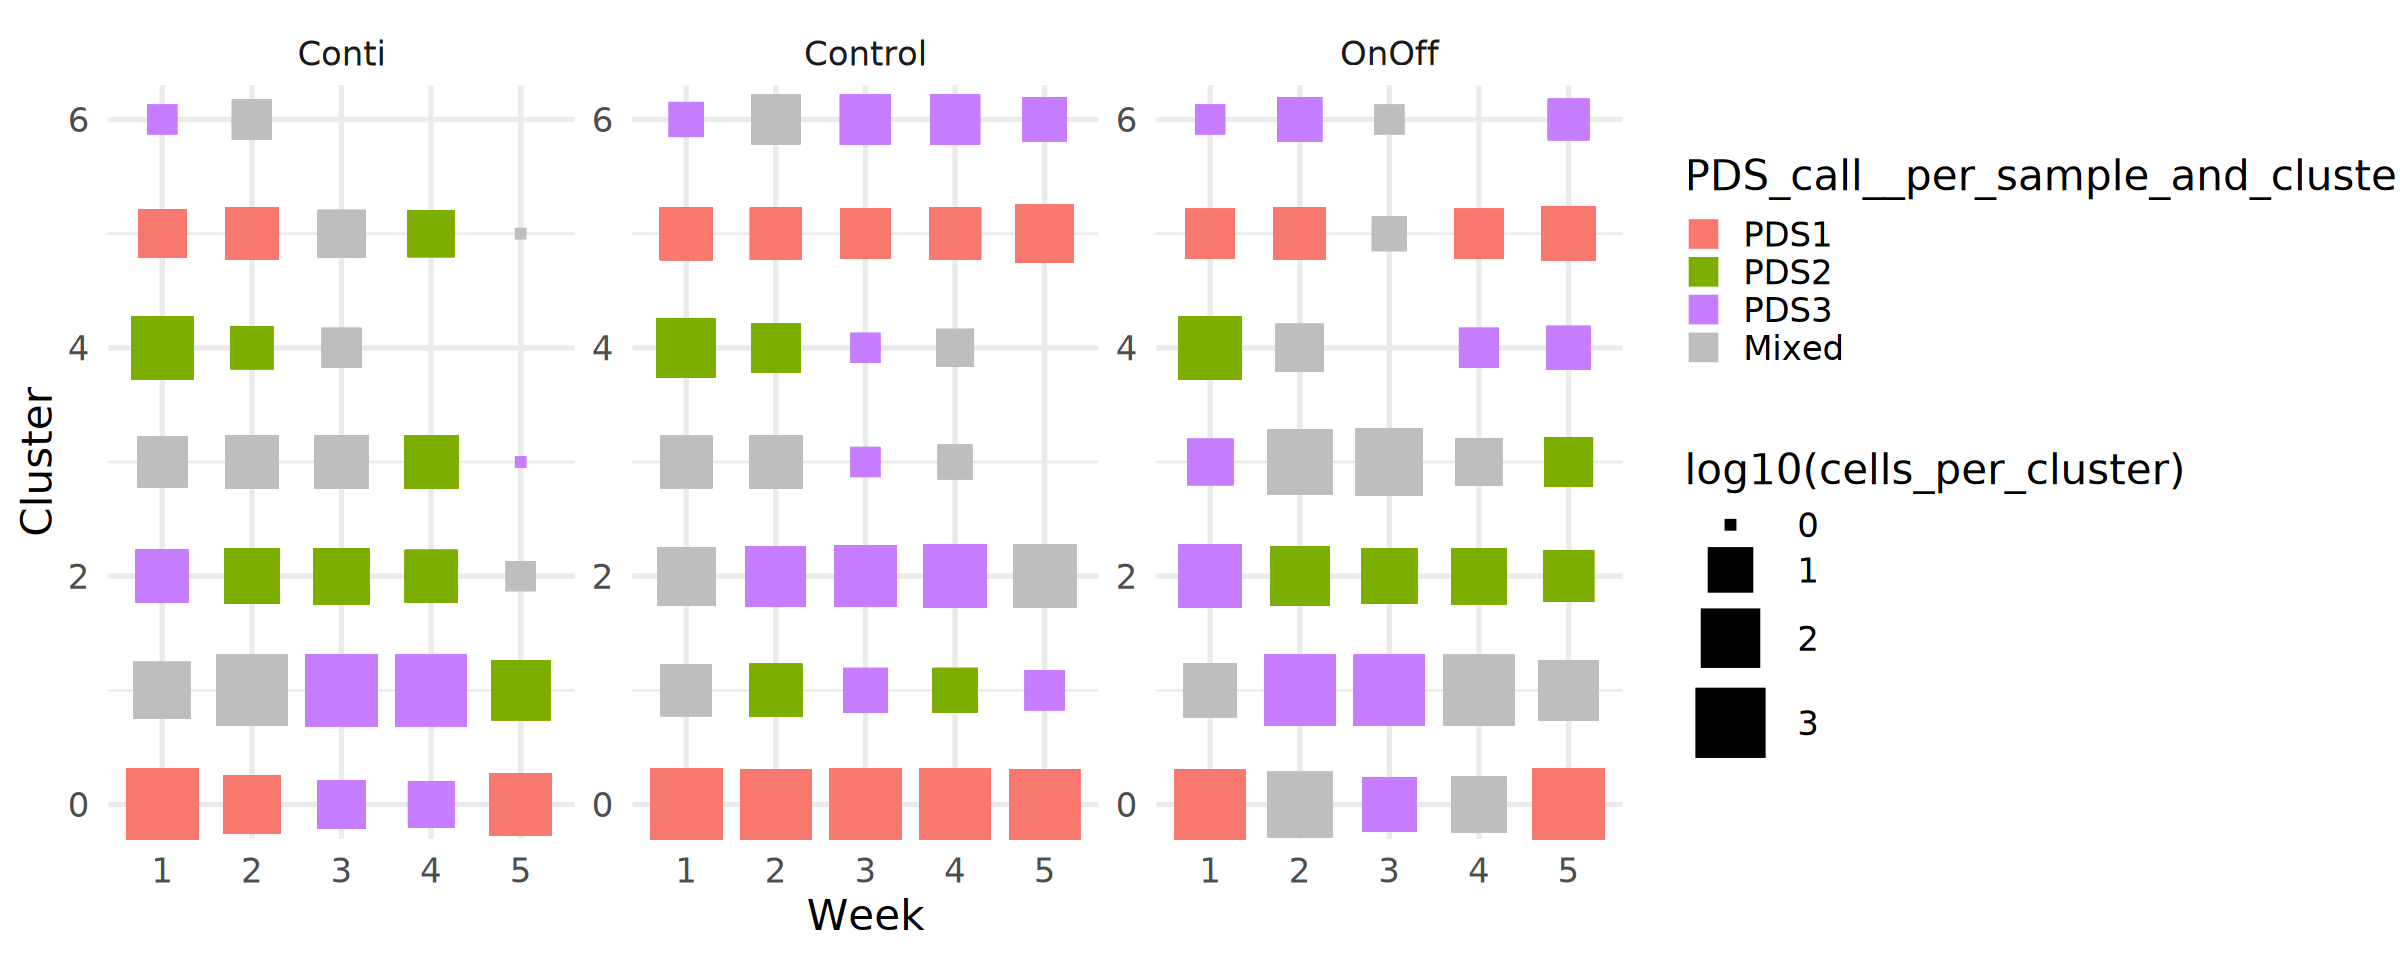

In [ ]:
# plot with PDS type per cluster and sample and the size of rectangles proportional to the number of cells in the cluster
options(repr.plot.width = 20, repr.plot.height = 8)
srt@meta.data %>%
    ggplot(aes(x = week, y = clusters, color = PDS_call__per_sample_and_cluster, size = log10(cells_per_cluster))) +
    geom_point(shape = 15) +
    scale_size_continuous(range = c(3, 20)) +
    scale_color_manual(values = pds_col, na.value="lightgrey", guide = guide_legend(override.aes = list(size = 8))) +
    theme_minimal(base_size = 25) +
    labs(x = "Week", y = "Cluster", fill = "PDS type") +
    facet_wrap(~treatment, scales = "free_y")

In [ ]:
library(tidyverse)
options(repr.plot.width = 20, repr.plot.height = 10)
PDS.predict_per_sample_and_cluster %>%
    mutate(week = str_remove(Sample_ID, ".*-") %>% str_remove("_.*"),
           treatment = str_remove(Sample_ID, "-.*"),
           cluster = str_remove(Sample_ID, ".*_"),
           treatment_cluster = paste0(treatment, "_", cluster)) %>%
    ggplot(aes(x = week, y = cluster, fill = PDS_call)) +
        geom_rect() +
        scale_fill_manual(values = pds_col, na.value="lightgrey") +
        labs(title = "PDS type per sample and cluster", x = "week", y = "treatment") +
        theme_minimal(base_size = 25) +
        facet_wrap(~treatment)

ERROR while rich displaying an object: Error in `geom_rect()`:
! Problem while setting up geom.
ℹ Error occurred in the 1st layer.
Caused by error in `compute_geom_1()`:
! `geom_rect()` requires the following missing aesthetics: xmin, xmax,
  ymin, and ymax.

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2r

## Pseudobulk per sample

What is the majority of PDS type when looking at samples in their entirety, just as we would see if it was a true bulk sample?

In [ ]:
aex_per_sample = AverageExpression(srt, layer = "data", assays = "RNA", 
                                   return.seurat = F, group.by = c("sample"))
aex_per_sample = as.data.frame(aex_per_sample$RNA)

# rownames to first column
aex_per_sample$Gene.Symbol = rownames(aex_per_sample)
aex_per_sample = aex_per_sample[,c(ncol(aex_per_sample), 1:(ncol(aex_per_sample)-1))]
rownames(aex_per_sample) = NULL
head(aex_per_sample)

Gene.Symbol C-1        C-2        C-3        C-4        C-5        Conti-1   
1 NOC2L       0.72500156 0.65041750 0.52243071 0.54693235 0.42393262 0.91121731
2 KLHL17      0.02588532 0.03366788 0.01753076 0.02775066 0.02910948 0.03004795
3 PLEKHN1     0.04845690 0.04302885 0.03920628 0.04466255 0.05947451 0.05979666
4 HES4        0.03664546 0.04392588 0.02871898 0.05451527 0.05118962 0.04043638
5 ISG15       0.56652901 0.70086324 0.37227373 0.43157824 0.32217928 0.94738774
6 AGRN        1.63391951 1.63518437 1.28351950 1.51038341 1.36080490 2.20313820
  Conti-2    Conti-3    Conti-4    Conti-5    OnOff-1    OnOff-2    OnOff-3   
1 0.70090837 0.46435629 0.51460371 0.48260408 0.79765584 0.57307387 0.45942021
2 0.03902219 0.02414529 0.02651796 0.02156553 0.02411595 0.02050579 0.03508575
3 0.13269457 0.08295573 0.10287555 0.12642402 0.03840624 0.08487197 0.07709979
4 0.07081479 0.02224139 0.05700535 0.05443896 0.01459948 0.02745025 0.04195738
5 1.08281358 1.11107335 1.33093064 0.81656775 0.62719435 1.03127834 1.29071733
6 2.08647433 1.85728724 2.47701328 1.84134838 1.89469545 1.73118282 2.14293312
  OnOff-4    OnOff-5   
1 0.46745218 0.67532371
2 0.03099510 0.04221299
3 0.10883666 0.05082806
4 0.05230881 0.06064438
5 0.70358010 0.43862354
6 2.06201534 1.51690280

In [ ]:
PDS.predict_per_sample = PDSpredict_fixed(aex_per_sample, species = "human", threshold = 0.6)
PDS.predict_per_sample

Calculating ssGSEA scores...



[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
ssGSEA Complete!


Batch Correction (with training set as reference batch)...



Batch Correction Complete!


Applying the svmRBF classification model...



Classification Complete!


Sample_ID PDS1        PDS2       PDS3        prediction PDS_call
C-1     C-1       0.966778615 0.02387556 0.009345825 PDS1       PDS1    
C-2     C-2       0.933290514 0.04065504 0.026054448 PDS1       PDS1    
C-3     C-3       0.750444760 0.09395844 0.155596797 PDS1       PDS1    
C-4     C-4       0.853099710 0.07997637 0.066923915 PDS1       PDS1    
C-5     C-5       0.684612957 0.13692906 0.178457987 PDS1       PDS1    
Conti-1 Conti-1   0.971472067 0.02148382 0.007044118 PDS1       PDS1    
Conti-2 Conti-2   0.033614629 0.51937484 0.447010532 PDS2       Mixed   
Conti-3 Conti-3   0.003687392 0.64041859 0.355894014 PDS2       PDS2    
Conti-4 Conti-4   0.004160156 0.65470863 0.341131209 PDS2       PDS2    
Conti-5 Conti-5   0.101127353 0.65783298 0.241039665 PDS2       PDS2    
OnOff-1 OnOff-1   0.918291678 0.05216554 0.029542785 PDS1       PDS1    
OnOff-2 OnOff-2   0.011725980 0.21385427 0.774419747 PDS3       PDS3    
OnOff-3 OnOff-3   0.004258314 0.24995916 0.745782521 PDS3       PDS3    
OnOff-4 OnOff-4   0.002831862 0.60130768 0.395860453 PDS2       PDS2    
OnOff-5 OnOff-5   0.968939597 0.02287707 0.008183336 PDS1       PDS1

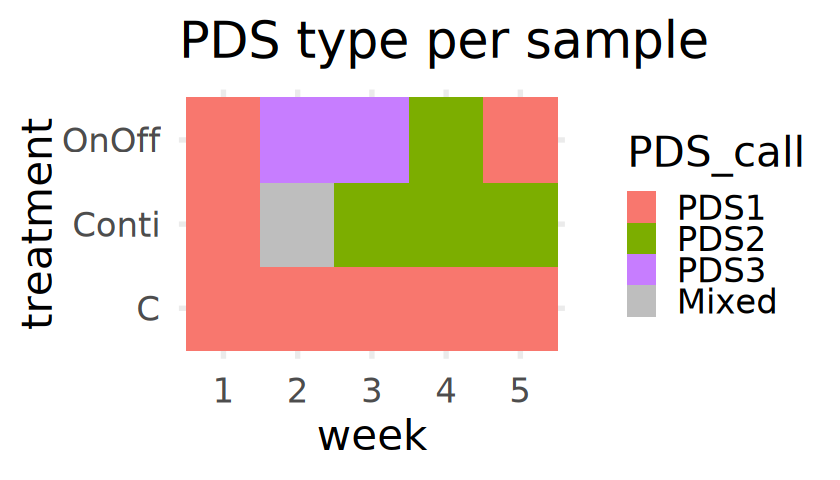

In [ ]:
library(tidyverse)
options(repr.plot.width = 7, repr.plot.height = 4)
PDS.predict_per_sample %>%
    mutate(week = str_remove(Sample_ID, ".*-"),
           treatment = str_remove(Sample_ID, "-.*")) %>%
    ggplot(aes(x = week, y = treatment, fill = PDS_call)) +
        geom_tile() +
        scale_fill_manual(values = pds_col, na.value="lightgrey") +
        labs(title = "PDS type per sample", x = "week", y = "treatment") +
        theme_minimal(base_size = 25)

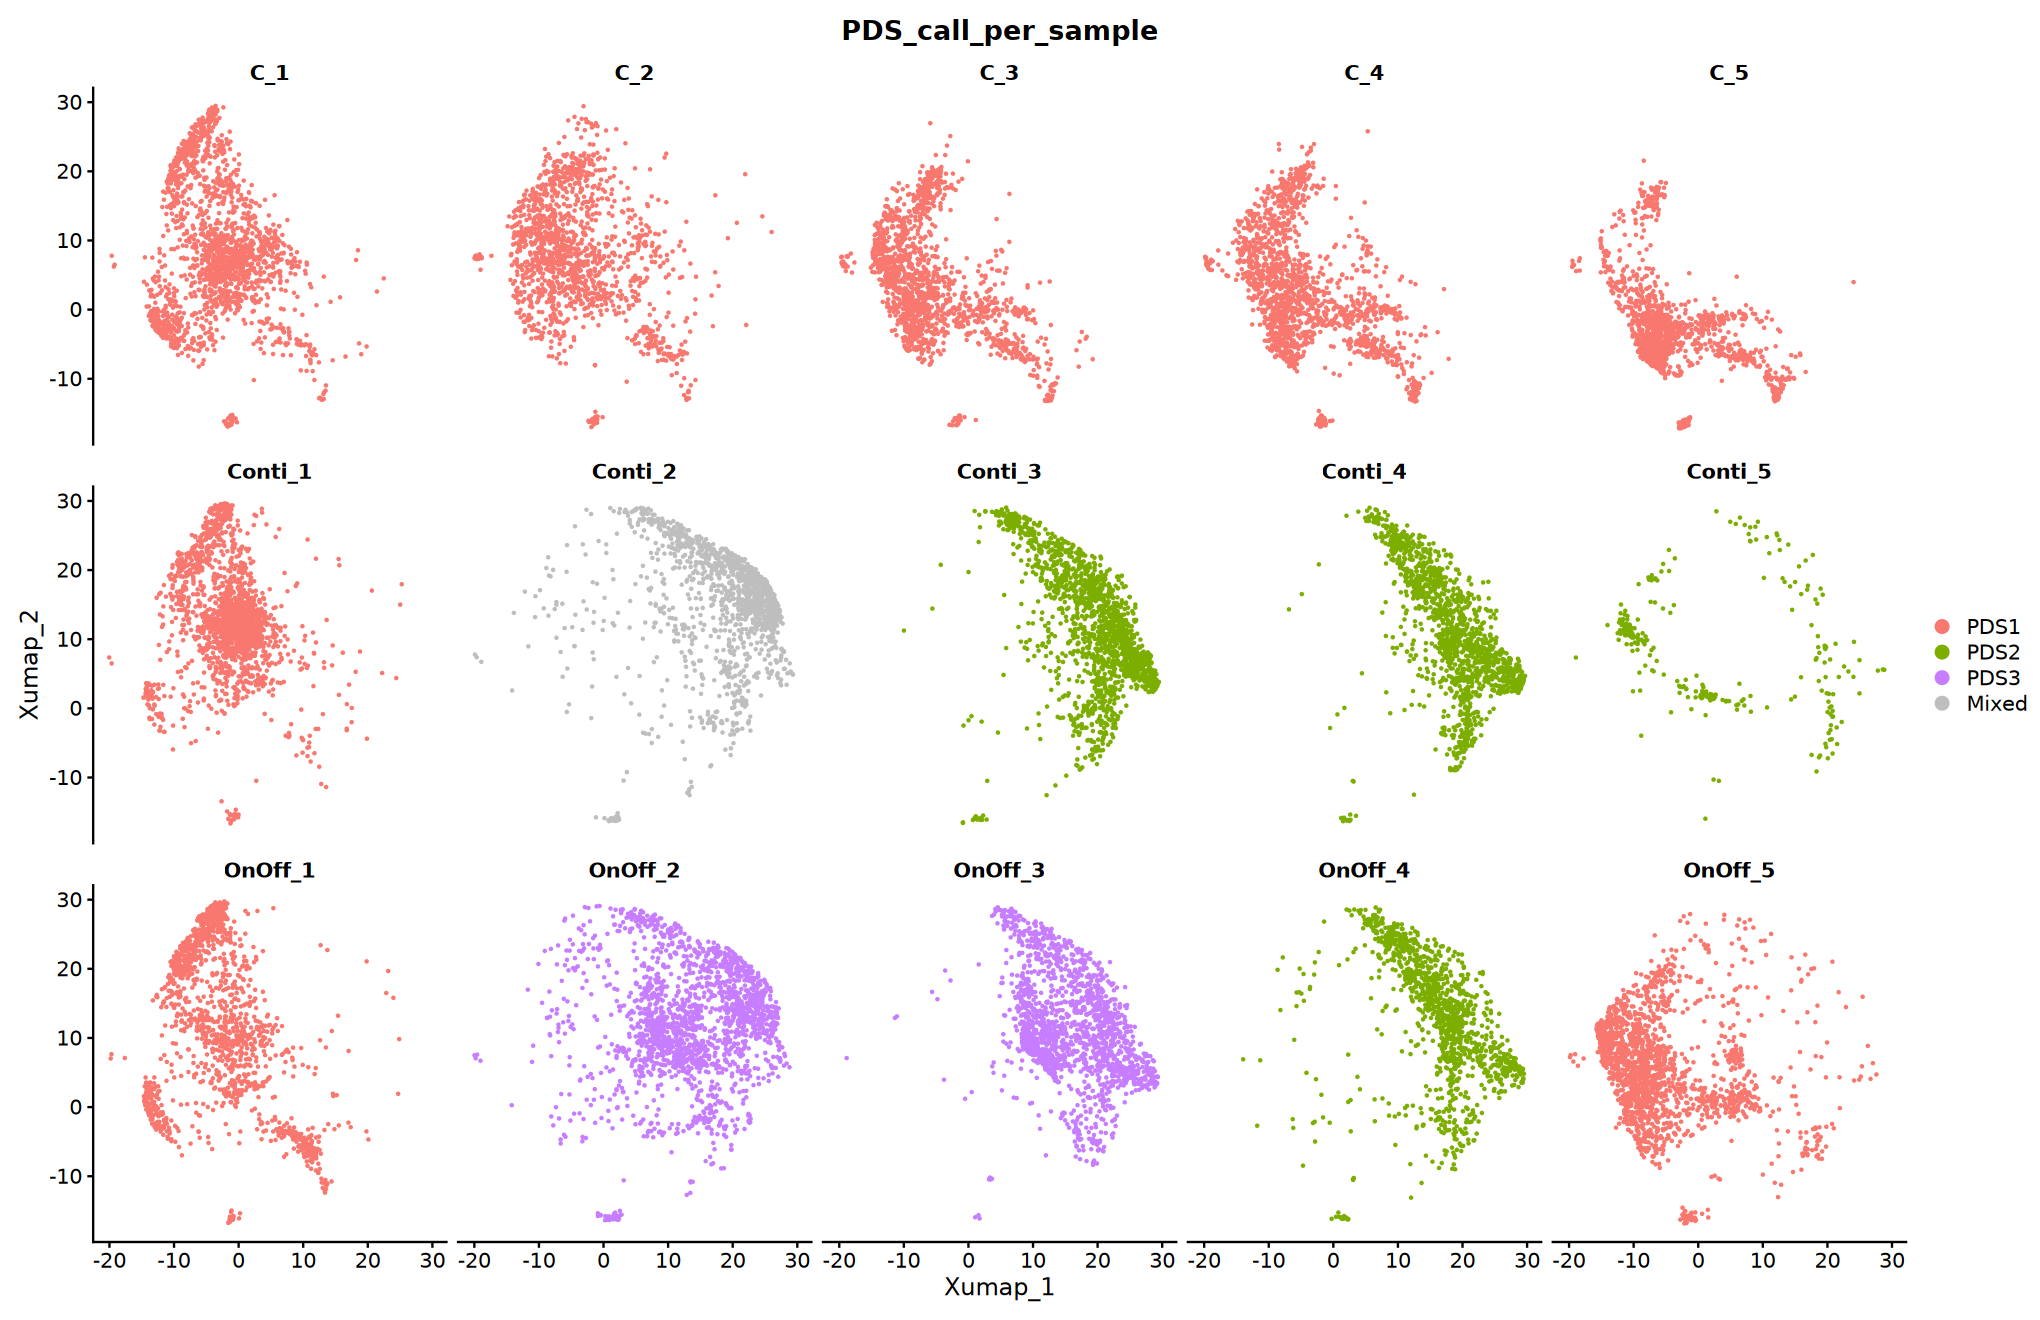

In [ ]:
# add to seurat object, associate sample with pds call
srt$PDS_call_per_sample = PDS.predict_per_sample$PDS_call[match(gsub("_", "-", gsub("_", "-", srt$sample)), PDS.predict_per_sample$Sample_ID)]
options(repr.plot.width = 17, repr.plot.height = 11)
DimPlot(srt, group.by = "PDS_call_per_sample", reduction = "umap", split.by = "sample", 
        ncol = 5, cols = pds_col, na.value="lightgrey")

# Stem Maturation Index (SMI)

> calculateSMI() function enable users to determine if the given sample (bulk tissue or single-cell) is transcriptionally stem-like or differentiated-like with Stem Maturation Index (SMI). The outcome provides single sample gene set enrichment analysis (ssGSEA) score for MYC targets and PRC targets, and from these, SMI is calculate (provided unscaled and scaled (-1 to 1)).

Figure 5n and 5j from their paper:

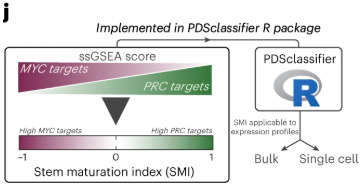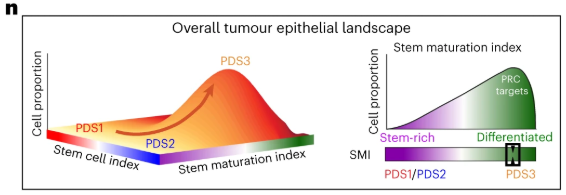

>Given the absence of stem populations in PDS3 and an association of MYC–PRC with stem–differentiation, we proposed a PDS-related stem–differentiation single sample scoring system for use in bulk and single-cell data, termed the ‘stem maturation index’ (SMI; Fig. 5j). Evaluation of the SMI in single-cell and bulk tissue datasets confirmed a clear correlation with PRC targets scores, differentiated colonic cells and PDS3 tumors (Fig. 5k,l and Extended Data Fig. 5i,j). Additionally, expression levels of several differentiation marker genes were also elevated in PDS3 and positively correlated with the SMI, further confirming PDS association along the phenotypic landscape of stem-to-differentiation, with PDS3 tumors having reduced stem populations and an increased abundance of epithelial cells that are further along the differentiated trajectory (Fig. 5m, Extended Data Figs. 5k,l and 6a,b).

>### Calculation of the SMI
>The SMI provides a method of transcriptomic measure along the stem–differentiation continuum in association with stem-like or differentiation-like properties. SMI can be calculated from the gene expression profile of both bulk tumor tissue and single-cell data and is simply the difference between the PRC targets and MYC targets ssGSEA score scaled between a value of −1 and 1. The method has also been implemented in the PDSclassifier R package in the form of the calculateSMI function.

As single cell data.

In [ ]:
library(escape)

In [ ]:
escape.matrix <- function(input.data, 
                          gene.sets = NULL, 
                          method = "ssGSEA", 
                          groups = 1000, 
                          min.size = 5,
                          normalize = FALSE,
                          make.positive = FALSE,
                          BPPARAM = SerialParam(),
                          ...) {
    egc <- .GS.check(gene.sets)
    cnts <- .cntEval(input.data, assay = "RNA", type = "counts")
    egc.size <- lapply(egc, function(x) length(which(rownames(cnts) %in% x)))
    if (!is.null(min.size)){
      remove <- unname(which(egc.size < min.size))
      if(length(remove) > 0) {
        egc <- egc[-remove]
        egc.size <- egc.size[-remove]
        if(length(egc) == 0) {
          stop("No gene sets passed the minimum length - please reconsider the 'min.size' parameter")
        }
      }
    }
    
    scores <- list()
    splits <- seq(1, ncol(cnts), by=groups)
    print(paste('Using sets of', groups, 'cells. Running', 
                length(splits), 'times.'))
    split.data <- .split_data.matrix(matrix=cnts, chunk.size=groups)
    
    all_gene_sets <- names(egc) # Collect all gene set names
    
    for (i in seq_along(splits)) {
      if (method == "GSVA") {
        parameters <- .gsva.setup(split.data[[i]], egc)
      } else if (method == "ssGSEA") {
        parameters <- .ssGSEA.setup(split.data[[i]], egc)
      }
      if (method %in% c("ssGSEA", "GSVA")) {
        a <- suppressWarnings(gsva(param = parameters, 
                                   verbose = FALSE,
                                   BPPARAM = BPPARAM,
                                   ...))
      } else if (method == "UCell") {
        a <- t(suppressWarnings(
          ScoreSignatures_UCell(matrix = split.data[[i]], 
                                features = egc,
                                name = NULL,
                                BPPARAM = BPPARAM,
                                ...)))
      } else if (method == "AUCell") {
        rankings <- AUCell_buildRankings(split.data[[i]],
                                         plotStats = FALSE,
                                         verbose = FALSE)
        a <- assay(AUCell_calcAUC(geneSets = egc,
                                  rankings,
                                  normAUC = TRUE,
                                  aucMaxRank = ceiling(0.2 * nrow(split.data[[i]])),
                                  verbose = FALSE,
                                  ...))
      }
      
      # Ensure consistent row names (all_gene_sets) across splits
      a <- as.data.frame(a)
      a <- a[match(all_gene_sets, rownames(a), nomatch = NA), , drop = FALSE]
      scores[[i]] <- a
    }
    scores <- do.call(cbind, scores)
    output <- t(as.matrix(scores))
    
    #Normalize based on dropout
    if(normalize) {
      output <- performNormalization(sc.data = input.data,
                                     enrichment.data = output,
                                     assay = NULL,
                                     gene.sets = gene.sets,
                                     make.positive = make.positive,
                                     groups = groups)
    }
    return(output)
}

.GS.check <- function(gene.sets) {
  if(is.null(gene.sets)) {
    stop("Please provide the gene.sets you would like to use for 
            the enrichment analysis")
  }
  egc <- gene.sets
  if(inherits(egc, what = "GeneSetCollection")){
    egc <- GSEABase::geneIds(egc) # will return a simple list, 
    #which will work if a matrix is supplied to GSVA
  }
  return(egc)
}


## The function below was taked from escape R package
cntEval <- function (obj)
{
  if (inherits(x = obj, what = "Seurat")) {
    cnts <- Seurat::GetAssayData(obj)
  }
  else if (inherits(x = obj, what = "SingleCellExperiment")) {
    cnts <- SingleCellExperiment::counts(obj)
  }
  else {
    cnts <- obj
  }
  if (!inherits(cnts, what = "dgCMatrix")) {
    cnts <- Matrix::Matrix(as.matrix(cnts), sparse = TRUE)
  }
  return(cnts)
}

In [ ]:
data = srt
datatype = "sc"
species = "human"
library(matrixStats)

### Select only human geneset by default ----
geneset <- myc_prc_gs_list[names(myc_prc_gs_list)[grep("_Human", names(myc_prc_gs_list))]]
names(geneset) <- gsub("_Human", "_Targets", names(geneset))

## to check, the number of genes matching, we will extract matrix from the single-cell data
## using function from escape:::cntEval
cnts <- escape:::cntEval(data)
### Check the proportion of genes in each geneset which are present in the expression data
genes_matched_prop <- lapply(geneset,
                              function(genes) sum(genes %in% rownames(cnts)) / length(genes))

## if less than 5 genes, stop or else calculate scores
if(all((genes_matched_prop < 0.05) == TRUE)) {
  stop("Less than 5 genes (minimum) from the genesets were found in the data.")
}

utils::packageVersion("escape")

## run escape to calculate scores ----
myc_prc_score <- escape::enrichIt(obj = data,
                                  gene.sets = geneset, method = 'ssGSEA',
                                  groups = 10000, cores = 4,
                                  min.size = 5)

[1] ‘1.12.0’

[1] "Using sets of 10000 cells. Running 3 times."
Setting parallel calculations through a SnowParam back-end
with workers=4 and tasks=100.
Estimating ssGSEA scores for 2 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
Setting parallel calculations through a SnowParam back-end
with workers=4 and tasks=100.
Estimating ssGSEA scores for 2 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
Setting parallel calculations through a SnowParam back-end
with workers=4 and tasks=100.
Estimating ssGSEA scores for 2 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."


In [ ]:
## into dataframe ----
myc_prc_score_copy <- as.data.frame(myc_prc_score)

## Calculate SMI (unscaled) ----
myc_prc_score_copy[["SMI_unscaled"]] <- myc_prc_score_copy[,1]-myc_prc_score_copy[,2] ## PRC - MYC
## Scale SMI between -1 to 1 ----
myc_prc_score_copy[["SMI"]] <- scales::rescale(myc_prc_score_copy[["SMI_unscaled"]], to = c(-1, 1))
myc_prc_score_copy |> head()

PRC_Targets MYC_Targets SMI_unscaled SMI       
GTAAGAACAGCTTTCGAACGGGAA-1 204.74675   1912.647    -1707.9002   -0.3824443
TGAATGTCACAGCAACATCCCAAC-1 -69.80765   1864.507    -1934.3147   -0.5114535
AAAGCGAAGCGATGGCATCCCAAC-1 588.65987   1375.822     -787.1619    0.1421852
ATGCGATAGTTGCGGAACAGACCT-1 450.40860   1036.237     -585.8284    0.2569035
AACTTACTCGCTATATACAGACCT-1 211.97860   1427.511    -1215.5321   -0.1018968
AGCCTTTCAACTTCGTACAGTCTG-1 580.98616   1098.044     -517.0579    0.2960884

In [ ]:
all(colnames(srt[['RNA']]$counts) == rownames(myc_prc_score_copy))

[1] TRUE

In [ ]:
# add results to seurat object
srt$PCR_Targets = myc_prc_score_copy$PRC_Targets
srt$MYC_Targets = myc_prc_score_copy$MYC_Targets
srt$SMI_unscaled_per_cell = myc_prc_score_copy$SMI_unscaled
srt$SMI_per_cell = myc_prc_score_copy$SMI

Warning message:
“Some of the plotted features are from meta.data slot.
• Please check that `na_cutoff` param is being set appropriately for those
  features.”


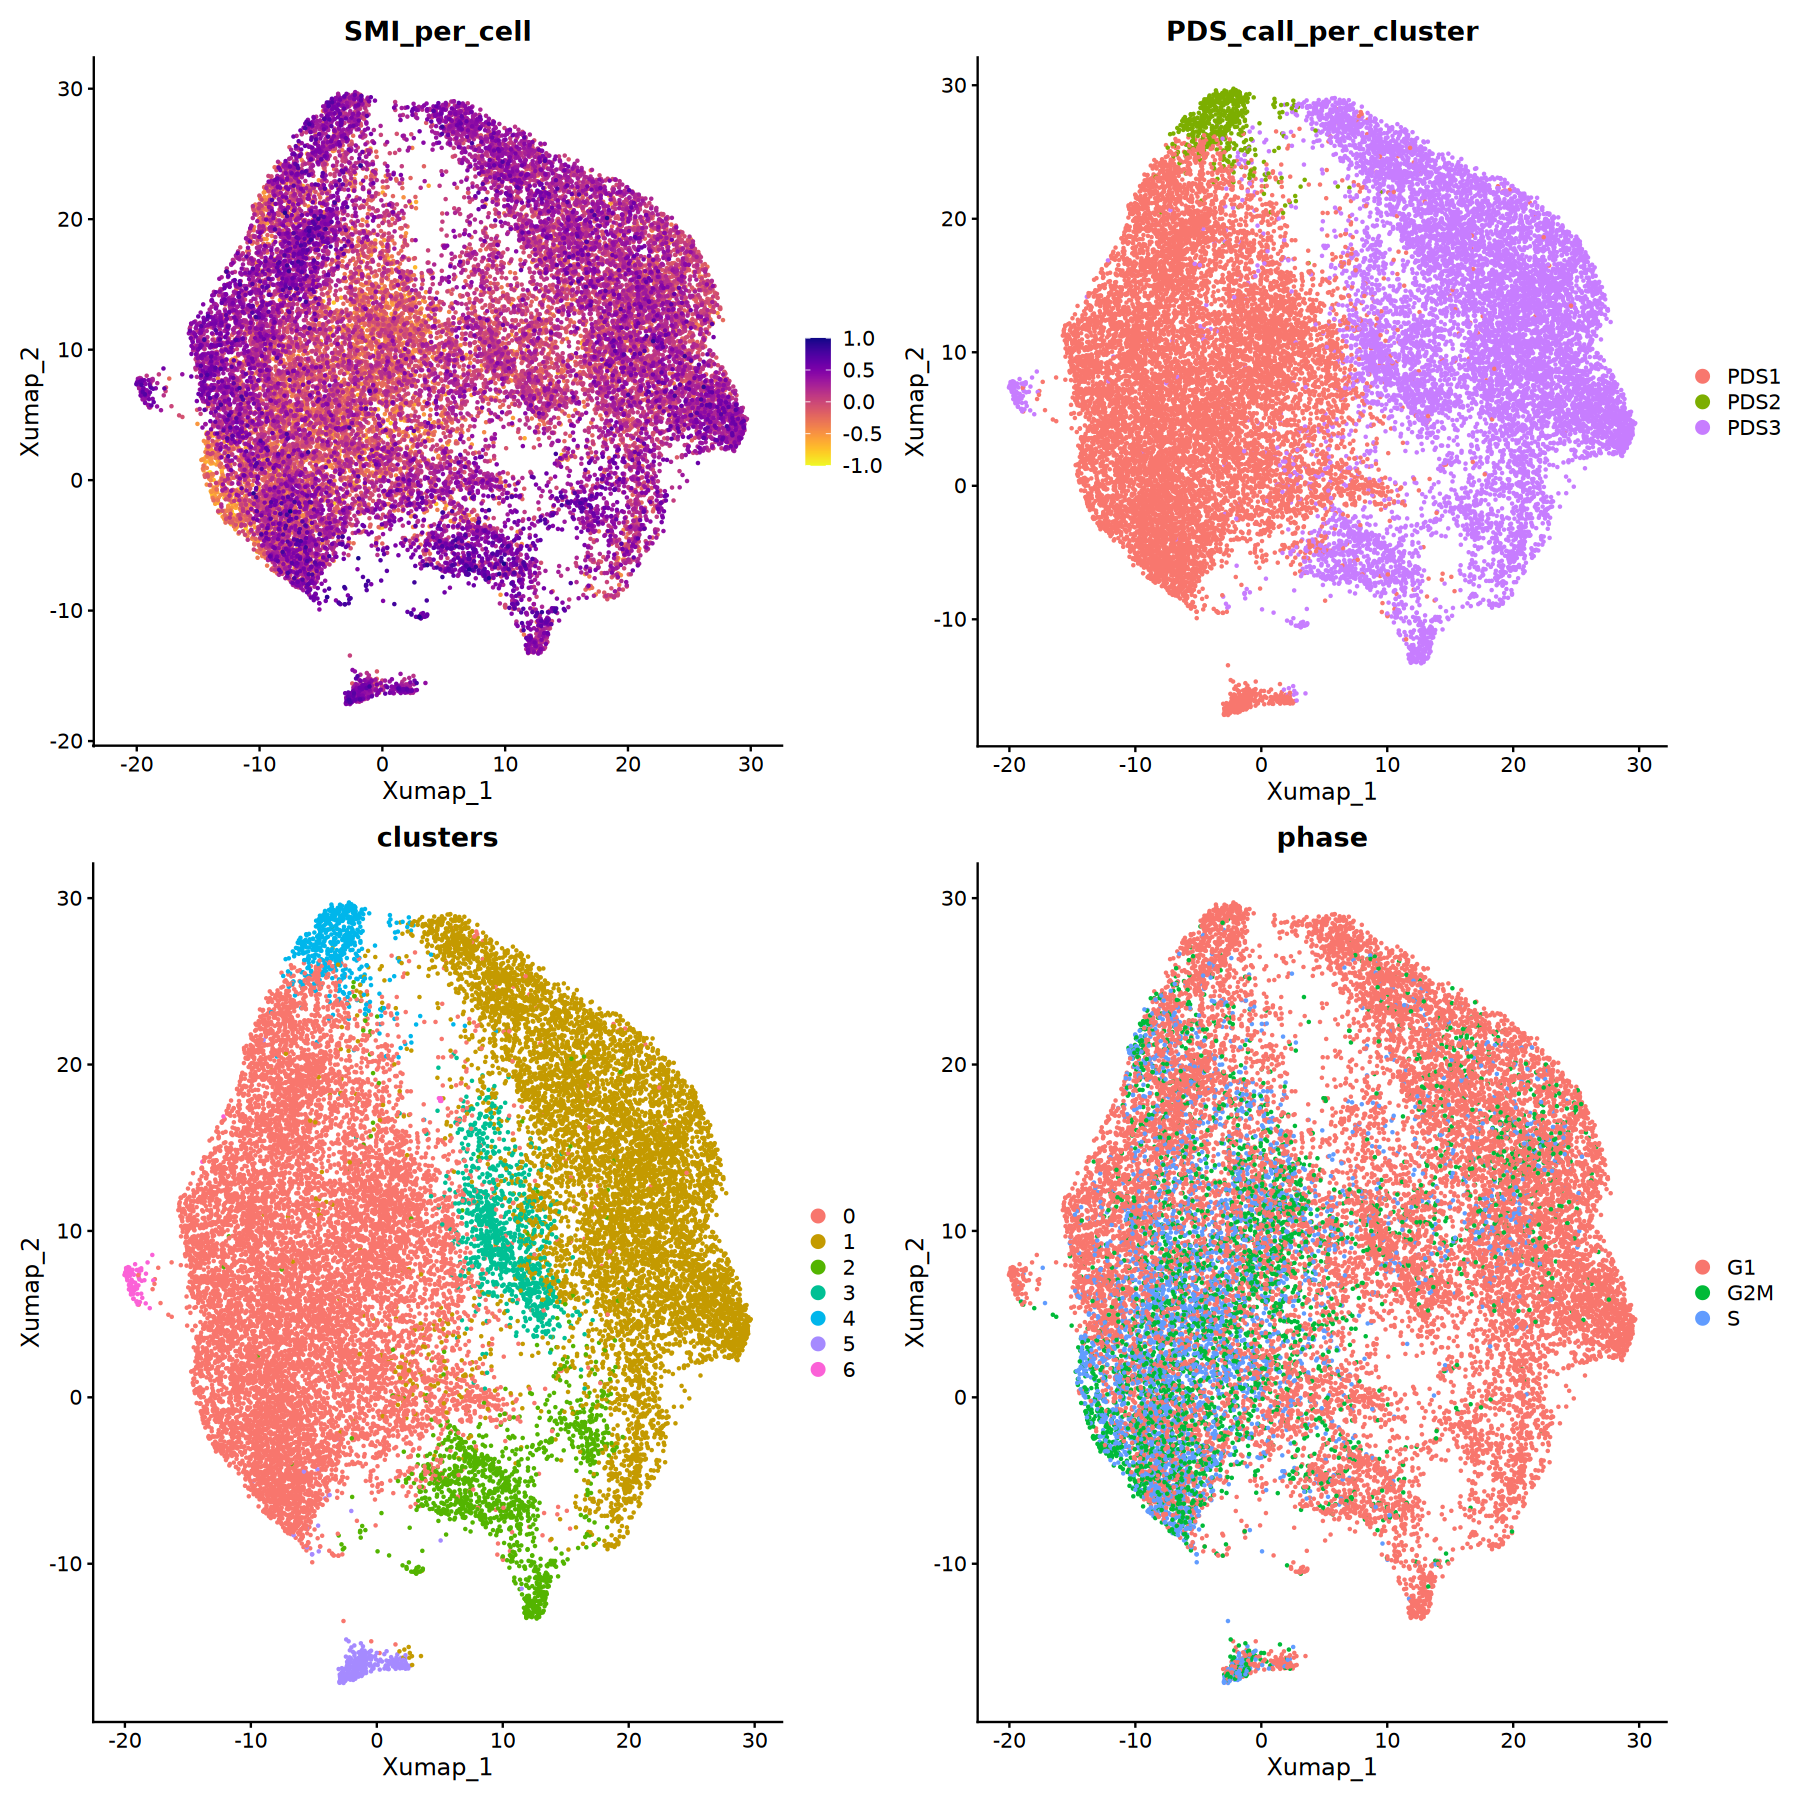

In [ ]:
library(scCustomize)
library(patchwork)
p5 = FeaturePlot_scCustom(srt, features = "SMI_per_cell", aspect_ratio=1, reduction = "umap", na_cutoff = NA)
options(repr.plot.width = 15, repr.plot.height = 15)
p5 + p1 + p2 + p3 + plot_layout(ncol = 2)

Warning message:
“Some of the plotted features are from meta.data slot.
• Please check that `na_cutoff` param is being set appropriately for those
  features.”


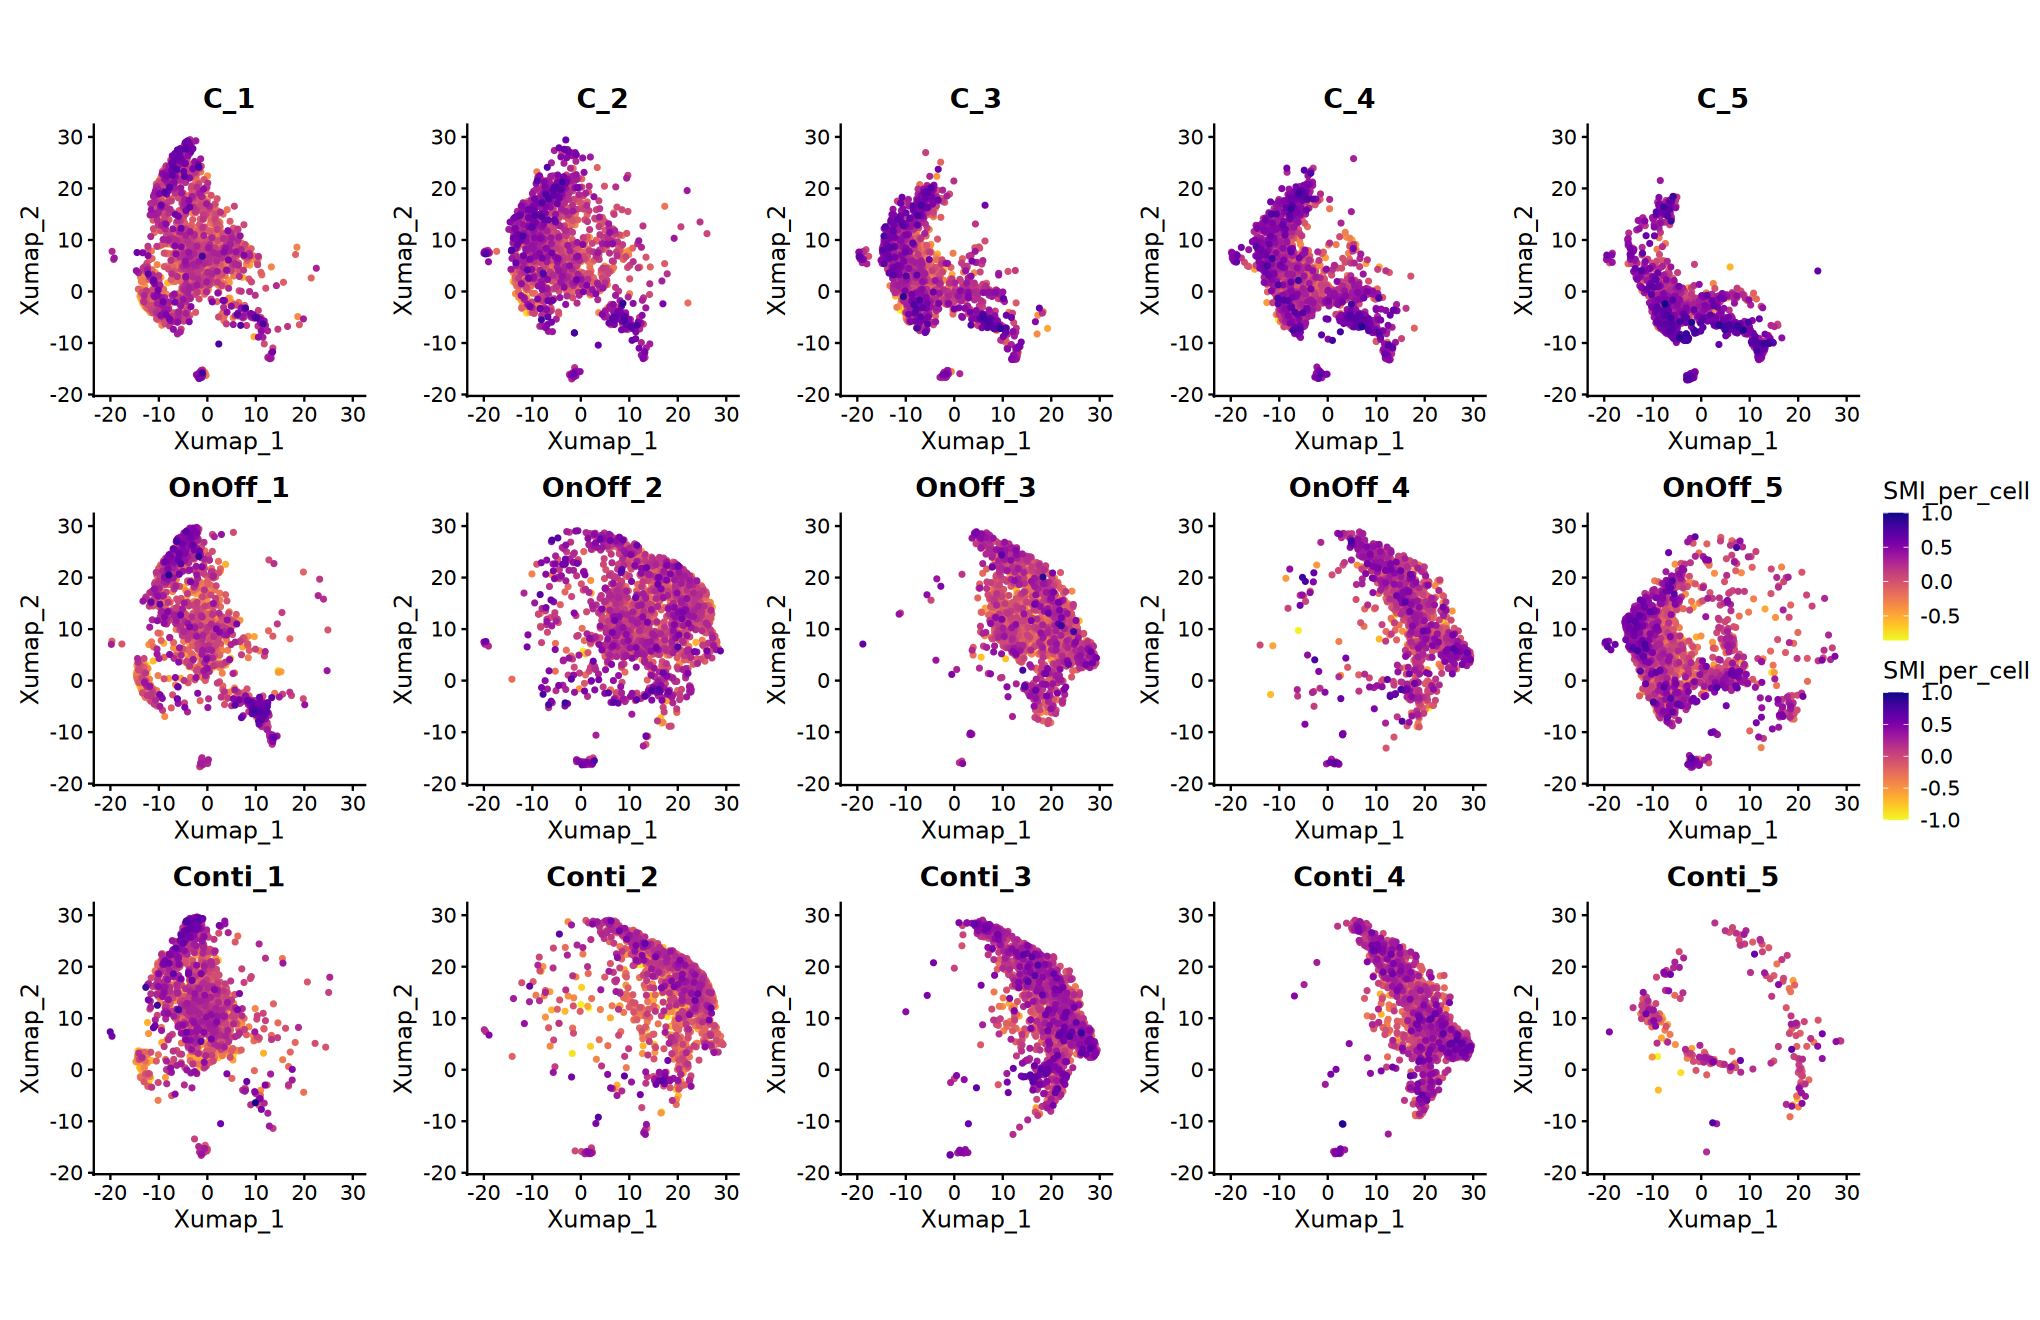

In [ ]:
srt$sample = factor(srt$sample, levels = c(paste0("C_", 1:5), paste0("OnOff_", 1:5), paste0("Conti_", 1:5)))
options(repr.plot.width = 17, repr.plot.height = 11)
FeaturePlot_scCustom(srt, features = "SMI_per_cell", num_columns = 5, split.by = "sample", aspect_ratio=1, reduction = "umap", na_cutoff = NA)